Notebook 3
==============
Modelling

# Importing Packages and Data

In [1]:
import pyfra
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier 
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import preprocessing
from sklearn.metrics import f1_score, accuracy_score, recall_score, make_scorer
from imblearn import under_sampling
from imblearn.under_sampling import RandomUnderSampler
from time import sleep
from sklearn.ensemble import AdaBoostClassifier

In [2]:
df = pd.read_pickle('../data/df.p')
n_rows_complete = len(df)

In [3]:
# Check whether or not the data is up-to-date (file can't be tracked on github because of it's file size)
pd.testing.assert_frame_equal(left=(pd.read_csv('../data/df_check_info.csv', index_col=0)), \
                         right=pyfra.df_testing_info(df),\
                         check_dtype=False, check_exact=False)

In [4]:
rus = RandomUnderSampler(random_state=23)

In [5]:
# Create a sample of the data, because the whole dataset is too big for us to work with
relative_sample_size = 0.01
df = df.sample(frac=relative_sample_size, random_state=23)

In [6]:
data = df.drop(columns='Severity',axis=1).select_dtypes(include=np.number).dropna(axis=1)
target = df['Severity']
data, target = rus.fit_resample(X=data, y=target)

In [7]:
target.value_counts()

1    1129
2    1129
3    1129
4    1129
Name: Severity, dtype: int64

In [8]:
print(f'We are working on {len(target)} data points, which represent {len(target)/n_rows_complete*100:.04f}% of the original data,')

We are working on 4516 data points, which represent 0.0948% of the original data,


In [9]:
X_train, X_test, y_train, y_test  = train_test_split(data, target, test_size=0.2 ,random_state=23)

# Scaling the Data and Selecting Features

In [10]:
std_scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = std_scaler.transform(X_train)
X_test_scaled = std_scaler.transform(X_test)

In [11]:
k_features = 25
kbest_selector = SelectKBest(k=k_features)
kbest_selector.fit(X_train_scaled,y_train);
X_train_scaled_selection = kbest_selector.transform(X_train_scaled)
X_test_scaled_selection = kbest_selector.transform(X_test_scaled)
print(f'We use {k_features} of the original {df.shape[1]} features')

We use 25 of the original 50 features


In [12]:
k_best_feature_names = data.columns[kbest_selector.get_support(indices=True)]

# Application of Machine Learning Models
## Setup of Metrics Table

In [13]:
# Creating a matrix to store the results
result_metrics = pd.DataFrame(columns=['model', 'f1', 'accuracy', 'recall'])
result_metrics

,model,f1,accuracy,recall


In [14]:
# Creating a function to compute and store the results for the respective model
def store_metrics(model_name, model, y_test, y_pred, result_df):
    result_df.loc[model_name, 'model'] = model
    result_df.loc[model_name, 'f1'] = f1_score(y_true=y_test, y_pred=y_pred, average='weighted')
    result_df.loc[model_name, 'accuracy'] = accuracy_score(y_true=y_test, y_pred=y_pred)
    result_df.loc[model_name, 'recall'] = recall_score(y_true=y_test, y_pred=y_pred, average='weighted')
    return result_df

## Setup of the Cross-Validator
We will use a repeated stratified cross-validation to make sure to pick the best parameters.
The stratification will be used to ensure an equal distribution of the different categories in every bin.
The repetition will be used in order ensure that the result is not an outlier. We will set a lower the number of repetitions, however, to save execution time (default would be 10 repetitions).

In [15]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=23)

## Support Vector Machine (SVM)

A support vector machine classifier will be used with parameter optimization via grid search.

### Setup of the SVM and the Grid Search

In [16]:
# Instantiation of the SVM Classifier
# We set the cache size to 1600 MB (default: 200 MB) to reduce the computing time.
# The other parameters will be set via grid search.
svc = svm.SVC(cache_size=1600)

# Choosing the parameters for the grid search
svc_params = {
    'kernel': ['poly', 'rbf', 'sigmoid'],
    'gamma': [0.1, 0.5, 'scale'],
    'C': [0.1, 0.5, 1, 2]
}

# Setup of the scoring. 
# We have to define the parameter 'average', because we are not dealing with a binary classification.
# Our sample is balanced, hence we can use a simple approach, using 'micro', which uses the global values of 
# true positives, false negatives and false positives.
f1_scoring = make_scorer(score_func=f1_score, average='micro')

# Instantiation of the GridSearchCv
# n_jobs is set to -1 to use all available threads for computation.
svc_grid = GridSearchCV(svc, param_grid=svc_params, scoring=f1_scoring, cv=cv, n_jobs=-1)

### SVM Parameter Optimization, Training and Prediction

In [17]:
# Fitting the grid search to find the best parameter combination
svc_grid.fit(X_train_scaled_selection, y_train)

# Print result of parameter optimization
print('Best parameter combination: ',svc_grid.best_params_)

# Predict target variable for the test set
svc = svc_grid.best_estimator_
y_svc = svc.predict(X_test_scaled_selection)


Best parameter combination:  {'C': 0.5, 'gamma': 'scale', 'kernel': 'rbf'}


### Metrics of SVM

In [18]:
# Calculate the metrics for the optimal svm model and store them in the result_metrics DataFrame 
# The model will be stored as well in the DataFrame
result_metrics = store_metrics(model=svc, model_name='Support Vector Machine',
                               y_test=y_test, y_pred=y_svc,
                               result_df=result_metrics)
# Show the interim result                               
result_metrics

,model,f1,accuracy,recall
Support Vector Machine,"SVC(C=0.5, cache_size=1600)",0.399442,0.418142,0.418142


## Random Forest
### Setup and GridSearch

In [19]:
params = {
    'criterion': ['gini'],
    'max_depth': [5,10,20],
    'min_samples_leaf':[3,7,15],
    'n_estimators': [50,100]
    }

RFCLF = GridSearchCV(RandomForestClassifier(),param_grid = params, cv = cv)
RFCLF.fit(X_train_scaled_selection,y_train)

print('Best Params are:',RFCLF.best_params_)
print('Best Score is:',RFCLF.best_score_)

Best Params are: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 15, 'n_estimators': 50}
Best Score is: 0.4352153040386509


### Optimized Model and Metrics

In [20]:
rf = RFCLF.best_estimator_
y_rf = rf.predict(X_test_scaled_selection)

cm = pd.crosstab(y_test,y_rf, rownames=['Real'], colnames=['Prediction'])
print(cm)

result_metrics = store_metrics(model=rf, model_name='Random Forest',
                               y_test=y_test, y_pred=y_rf,
                               result_df=result_metrics)
                              
result_metrics

Prediction    1    2   3   4
Real                        
1           112   40  20  56
2            21  153  35  24
3            50   78  45  56
4            74   33  21  86


,model,f1,accuracy,recall
Support Vector Machine,"SVC(C=0.5, cache_size=1600)",0.399442,0.418142,0.418142
Random Forest,"(DecisionTreeClassifier(max_depth=20, max_feat...",0.421882,0.438053,0.438053


# Logistic Regression

In [21]:
#We use and define logistic Regression with n_jobs=-1 to use all cores
LR = LogisticRegression()
#for parameters we use 3 type of solver and 6 for C
LR_params = {
    'solver': ['liblinear', 'lbfgs', 'saga'], 
    'C': [10**(i) for i in range(-5, 5)]
}

f1_scoring = make_scorer(score_func=f1_score, average='micro')

# Instantiation of the GridSearchCv
LR_grid = GridSearchCV(LR, param_grid=LR_params, scoring=f1_scoring, cv=cv, n_jobs=-1)


# LR Parameter Optimization, Training and Prediction

In [22]:
# Fitting the grid search to find the best parameter combination
LR_grid.fit(X_train_scaled_selection, y_train)

# Print result of parameter optimization
print('Best parameter combination: ',LR_grid.best_params_)

# Predict target variable for the test set
LR = LR_grid.best_estimator_
y_LR = LR.predict(X_test_scaled_selection)

Best parameter combination:  {'C': 0.1, 'solver': 'lbfgs'}


## Metrics of LR

In [23]:
# Calculate the metrics for the optimal LR model and store them in the result_metrics DataFrame 
# The model will be stored as well in the DataFrame
result_metrics = store_metrics(model=LR, model_name='Logistic Regression',
                               y_test=y_test, y_pred=y_LR,
                               result_df=result_metrics)
# Show the interim result                               
result_metrics

,model,f1,accuracy,recall
Support Vector Machine,"SVC(C=0.5, cache_size=1600)",0.399442,0.418142,0.418142
Random Forest,"(DecisionTreeClassifier(max_depth=20, max_feat...",0.421882,0.438053,0.438053
Logistic Regression,LogisticRegression(C=0.1),0.388846,0.399336,0.399336


# Decision Tree

## Setup of the DT and the Grid Search

In [24]:
from sklearn import tree
from sklearn.pipeline import Pipeline

# Grid
criterion = ['gini', 'entropy']
max_depth = [2,4,6,8,10,12]
parameters = dict(criterion=criterion, max_depth=max_depth)

DT = GridSearchCV(DecisionTreeClassifier(),param_grid = parameters, cv = RepeatedKFold(n_splits=4, n_repeats=1, random_state=23))
# 
DT.fit(X_train_scaled_selection,y_train)

# 
print('Best Criterion:', DT.best_estimator_.get_params())
print('Best max_depth:', DT.best_estimator_.get_params())
print(); print(DT.best_estimator_.get_params())

Best Criterion: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 4, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}
Best max_depth: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 4, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 4, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}


## Metrics of Decision Tree

In [25]:
dt = DT.best_estimator_
y_dt = dt.predict(X_test_scaled_selection)
cm = pd.crosstab(y_test,y_dt, rownames=['Real'], colnames=['Prediction'])
print(cm)
result_metrics = store_metrics(model=dt, model_name='Decision Tree',
                               y_test=y_test, y_pred=y_dt,
                               result_df=result_metrics)
                              
result_metrics

Prediction   1    2  3    4
Real                       
1           34   60  0  134
2            9  168  8   48
3           26   99  6   98
4           20   49  0  145


,model,f1,accuracy,recall
Support Vector Machine,"SVC(C=0.5, cache_size=1600)",0.399442,0.418142,0.418142
Random Forest,"(DecisionTreeClassifier(max_depth=20, max_feat...",0.421882,0.438053,0.438053
Logistic Regression,LogisticRegression(C=0.1),0.388846,0.399336,0.399336
Decision Tree,"DecisionTreeClassifier(criterion='entropy', ma...",0.316249,0.390487,0.390487


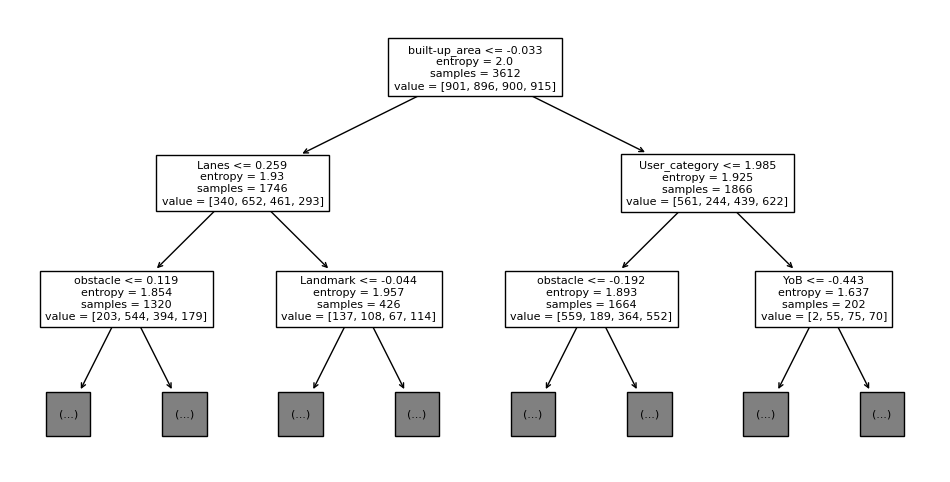

In [26]:
# ## Interpretation of the Decision Tree
# Decision trees are known to have a high interpretability compared to other machine learning models. The performance of the applied model is worse than the ones of the other models, but we can easily plot the tree and gain insights.
from sklearn.tree import plot_tree
fig = plt.figure(figsize=(12,6));
plot_tree(dt,max_depth=2, fontsize=8, feature_names=k_best_feature_names);

# The plot shows that the most important feature (according to the decision tree) is built-up_area. This binary variable cointains the information, whether the accident happened in a built-up area. We already showed in the first notebook that there seems to be a positive relation between the density of an area and it's **number** of accident. The decision tree here suggests that the **severity** is also affected by a dense population.

# Application of Advanced Models

## Stacking Classifier

In [27]:
estimators = [('lr', LR), ('svc', svc), ('rf', rf)]
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=svc, cv='prefit', n_jobs=-1)

stacking_clf.fit(X_train_scaled_selection, y_train)
y_stacking = stacking_clf.predict(X_test_scaled_selection)
result_metrics = store_metrics(model=stacking_clf, model_name='Stacking',
                               y_test=y_test, y_pred=y_stacking,
                               result_df=result_metrics)
result_metrics

,model,f1,accuracy,recall
Support Vector Machine,"SVC(C=0.5, cache_size=1600)",0.399442,0.418142,0.418142
Random Forest,"(DecisionTreeClassifier(max_depth=20, max_feat...",0.421882,0.438053,0.438053
Logistic Regression,LogisticRegression(C=0.1),0.388846,0.399336,0.399336
Decision Tree,"DecisionTreeClassifier(criterion='entropy', ma...",0.316249,0.390487,0.390487
Stacking,"StackingClassifier(cv='prefit',\n ...",0.40707,0.422566,0.422566


# ADA Boosting

In [28]:
#Trying ADA boosting on LogisticRegresiion
ADA_Boost = AdaBoostClassifier(estimator = LR , n_estimators = 1000)
ADA_Boost.fit(X_train_scaled_selection, y_train)
y_ada = ADA_Boost.predict(X_test_scaled_selection)

In [29]:
result_metrics = store_metrics(model=ADA_Boost, model_name='ADA Boost',
                               y_test=y_test, y_pred=y_ada,
                               result_df=result_metrics)
# Show the interim result                               
result_metrics

,model,f1,accuracy,recall
Support Vector Machine,"SVC(C=0.5, cache_size=1600)",0.399442,0.418142,0.418142
Random Forest,"(DecisionTreeClassifier(max_depth=20, max_feat...",0.421882,0.438053,0.438053
Logistic Regression,LogisticRegression(C=0.1),0.388846,0.399336,0.399336
Decision Tree,"DecisionTreeClassifier(criterion='entropy', ma...",0.316249,0.390487,0.390487
Stacking,"StackingClassifier(cv='prefit',\n ...",0.40707,0.422566,0.422566
ADA Boost,"(LogisticRegression(C=0.1, random_state=773586...",0.370354,0.379425,0.379425



# Results and Conclusion

## Comparison of the Performances

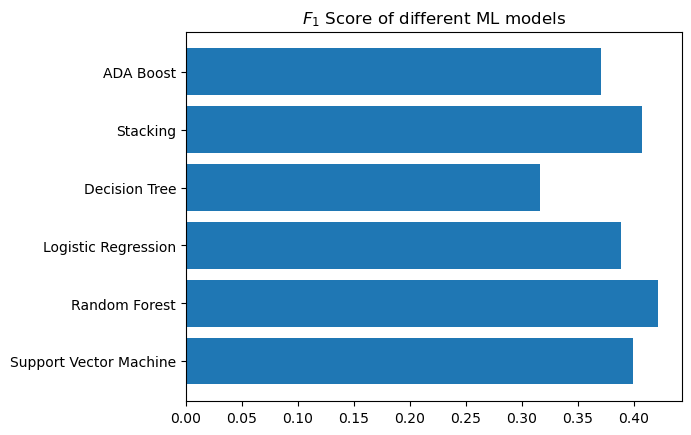

In [30]:
plt.barh(y=result_metrics.index.values, width=result_metrics['f1']);
plt.title('$F_1$ Score of different ML models');

The results show a comparable performance for all machine learning models, with the advanced stacking classifier giving the best score (f_1) and the decision tree giving the worst score. 

There are a few things to consider when analyzing these results.
1. We worked on a very small partition of the dataset in order to achieve acceptable execution times. We expect to reach higher performances when working with more data.
2. The classifiers based on logistic regression and decision trees have low scores, are not necessarily unfit for the dataset, as they offer more interpretability than the advanced models. This interpretability could help e.g. policy makers to take measures in order to reduce the severity of road accidents.
3. A strong correlation between severity and safety measurements (e.g. safety belt) is expected. Unfortunately, this feature could not be used because useful is only available for the last years (2018--).

## Analysis of the Correlation Matrix

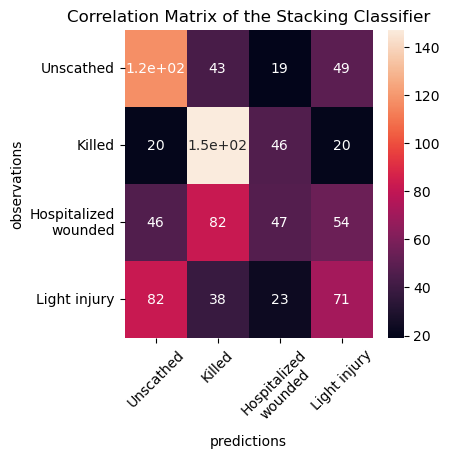

In [31]:
cm = pd.crosstab(y_test, y_stacking, rownames=['observations'], colnames=['predictions']);
severity_categories = ("Unscathed","Killed", "Hospitalized\nwounded", "Light injury")
plt.figure(figsize=(4,4))
plt.title('Correlation Matrix of the Stacking Classifier');
sns.heatmap(cm, annot=True);
plt.xticks(np.array(range(4))+0.5, labels=severity_categories, rotation=45);
plt.yticks(np.array(range(4))+0.5, labels=severity_categories, rotation=0);

The correlation matrix of the stacking classifier shows that some categories are more difficult to predict than others. The category "Hospitalized wounded" seems to be the most difficult to predict, as the predictions seem to be quite evenly distributed between the different classes. We can quantify these difficulties by looking at the scores for accuracy and recall for each category.

In [32]:
from sklearn.metrics import classification_report
severity_categories = ("Unscathed","Killed", "Hospitalized wounded", "Light injury")
print(classification_report(y_true=y_test, y_pred=y_stacking, target_names=severity_categories))

                      precision    recall  f1-score   support

           Unscathed       0.44      0.51      0.47       228
              Killed       0.47      0.63      0.54       233
Hospitalized wounded       0.35      0.21      0.26       229
        Light injury       0.37      0.33      0.35       214

            accuracy                           0.42       904
           macro avg       0.41      0.42      0.41       904
        weighted avg       0.41      0.42      0.41       904



The classification report reflects our observations from the correlation matrix. It is satisfying that the categorie "Killed" is predicted with the highest accuracy; we consider this category as particularly important.

In [33]:
# Saving the models for further use and investigation
from joblib import dump, load


dump(stacking_clf, '../models/stacking_clf.joblib')

['../models/stacking_clf.joblib']

In [34]:
loaded_model = load('../models/stacking_clf.joblib')
y_test_loaded = loaded_model.predict(X_test_scaled_selection)